In [1]:
import torch
from torch.autograd import Variable
from torch.distributions import Normal
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss
import pickle
import random

In [2]:
import sys
sys.path.insert(0,'vp_class/')

In [3]:
from class_tou_v4_updated import tOU, tou_gradient

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.64 and 0.01 repectively.

m(t) = $\alpha$t + $m_{0}$

1. Simulate prior process, i.e. double-well system whose SDE is given by

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

In [4]:
with open('EX03_DW', 'rb') as f:
    prior = pickle.load(f)
    likelihood = pickle.load(f)
    std = pickle.load(f)

In [5]:
def prior_drift (s, x_s):
    return 4 * x_s * (1 - (x_s ** 2))

In [6]:
true_sde_pts, true_sde_trj = prior[0], prior[1]
obs, obs_time = likelihood[0], likelihood[1]
sde_sigma, obs_sigma = std[0], std[1]

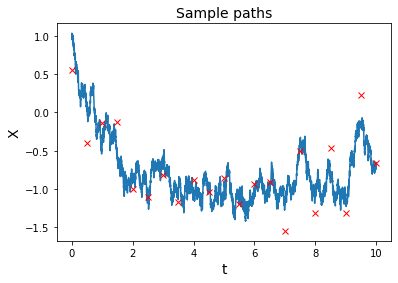

In [7]:
# Plot paths
plt.plot(true_sde_pts,true_sde_trj)
plt.plot(obs_time, obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


In [8]:
true_sde_pts = torch.from_numpy(true_sde_pts)
true_sde_trj = torch.from_numpy(true_sde_trj)

obs = torch.from_numpy(obs)
obs_time = torch.from_numpy(obs_time)

Variational inference: KL

2. Implement Variational inference based on $\textbf{time-inhomogeneous}$ OU process with SDE:

$$dX_{t} = [-\frac{a}{at+b}X_{t} + (ct+d)] dt + \sigma^{2} dW_{t}$$

$$\mathbb{E}_{P^{Z}}[\log\exp{\frac{dP^{X}}{dP^{Z}}(Z)] = \frac{1}{2}\mathbb{E}_{P^{Z}}[\int_{t_{0}}}^{t_{1}}|\frac{4Z_{t}(1-Z^{2}_{t}) + \frac{a}{at+b}Z_{t} - (ct+d)}{\sigma}|^{2}dt]$$


In [9]:
class ELBO:
    """
        ELBO with
            variational process (q): time-inhomogeneous OU process
            prior process (p): double-well system
            
        This class computes: - KL(q|p) + NLL(y|z)  where z \sim q
    """
    def __init__(self, ou):
        self.ou = ou
        
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.r = ou.r
        
        self.sigma = ou.sigma
        

    def KL(self, prior_drift):
        """
            This function requires the function corresponding to prior drift function
        """
        # Save parameter specification from ou class
        alpha, beta, r, sigma = self.alpha, self.beta, self.r, self.sigma
        m0 = self.ou.trj[:, 0].reshape(-1, 1)
        
        def B(s, beta):
            return (s+1) ** beta
        
        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1)
        
        # Evaluate the drift function of the approximating processes
        g_of_x = -r * (self.ou.trj - m(t)) + m_(t)
        
        # Evaluate the drift function of the model (prior process)
        f_of_x = prior_drift(t, self.ou.trj)
        
        # Compute the term inside the KL divergence
        
        F_of_X = abs(((f_of_x - g_of_x) / sigma) ** 2)
        
        dt = t[:, -1] - t[:, 0]
        
        return 0.5 * torch.sum(F_of_X, axis=1).reshape(-1, 1) / F_of_X.shape[1] * dt.reshape(-1, 1)
            
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference: a piece-wise approximation**

In [10]:
import tqdm as tq

In [11]:
def score_estimate(s0, sK, current_pars, sigma, obs, obs_sigma, init_dist, M, K):
    """
        Returns stochastic estimates of the gradient of the ELBO with respect to parameters including
            alpha, r, beta
        
        M: # of Monte Carlo samples
        
    """
    assert obs.shape[0] == 1, "observation must be 1-d torch.array"
    
    
    # Reshape every parameter into (M,1) torch.array
    SIGMA = sigma.repeat(M, 1)
    OBS = obs.repeat(M, 1)
    # Simulate sample path
    # Note that z0 = m0
    
    pars = {key:val.repeat(M, 1) for key,val in current_pars.items()}
    
    vi = tOU(t0=s0, t1=sK, parameters = pars, sde_sigma=SIGMA, init_dist = init_dist, timegrid = 'False', dN=K)

    # Compute the ELBO 
    elbo = ELBO(vi)
    score_func = tou_gradient(vi.pts, vi.trj, pars, SIGMA, init_dist)
    f_of_x = -elbo.log_prob(OBS, obs_sigma) + elbo.KL(prior_drift)
    
    # Variational objective
    vi_obj = {'NELBO': torch.nanmean(f_of_x).item(), 'KL': torch.nanmean(elbo.KL(prior_drift)).item(), 'NLL': -1 * torch.nanmean(elbo.log_prob(OBS, obs_sigma)).item() }
    
    return {key: torch.nanmean(f_of_x * score_func[key]) for key in pars.keys()}, vi_obj

In [12]:
def AdamStep(g_t, m_t, v_t, beta_1, beta_2, t):
    """
        compute bias corrected moments
    """
#     print(g_t, m_t, v_t, beta_1, beta_2, t)
    m_t_next = beta_1 * m_t + (1 - beta_1) * g_t
    v_t_next = beta_2 * v_t + (1 - beta_2) * g_t ** 2
    
    m_t_corrected = m_t_next / (1 - (beta_1 ** t))
    v_t_corrected = v_t_next / (1 - (beta_2 ** t))
    
#     print(m_t_corrected, v_t_corrected)
    return m_t_corrected, v_t_corrected

def AdamGrad(current_pars, current_grad, prev_moments,  beta_1, beta_2, learning_rate = 0.01, smooth_term = 1e-8):
    assert type(current_pars) == type(current_grad) == type(prev_moments) == dict, "Current_grad must be a dict"
    """
        Perform one-step Adam gradient descent
    """
    new_pars = {}
    for key in current_pars.keys():
        if key == 'r':
            m_t, v_t = AdamStep(current_grad[key], prev_moments[key][0], prev_moments[key][1], beta_1, beta_2, prev_moments['t'])
            new_pars[key] = current_pars[key] - learning_rate / np.sqrt(v_t + smooth_term) * m_t
            value = new_pars[key]
            lr = learning_rate
            while value <= 0:
                value = current_pars[key] - lr / np.sqrt(v_t + smooth_term) * m_t
                lr *= 0.5
            new_pars[key] = value
            
        else:
            m_t, v_t = AdamStep(current_grad[key], prev_moments[key][0], prev_moments[key][1], beta_1, beta_2, prev_moments['t'])
            new_pars[key] = current_pars[key] - learning_rate / np.sqrt(v_t + smooth_term) * m_t
        
        # Save moments for next iteration    
        prev_moments[key][0] = m_t
        prev_moments[key][1] = v_t
    
    prev_moments['t'] += 1
    
    return new_pars
    
    
    

In [13]:
def E_of_X ( init_pts, pts, parameters ):
    """
        Return mean of the process (which has analytical expression)
    """

    alpha = parameters['alpha']
    beta = parameters['beta']
    r = parameters['r']
    
    return alpha * ((pts + 1) ** beta - 1) + init_pts
    

In [14]:
def V_of_X (pts, parameters, prev_parameters, sde_sigma):
    """
        Return standard deviation of the process (from its analytical expression)
    """
    r = parameters['r']
    
    if prev_parameters == False:
        # for the first time step, we compute the variance given the initial point is fixed
        return torch.sqrt(0.5 * sde_sigma * sde_sigma / r * (1 - torch.exp(-2 * r * pts)))
    
    else:
        # for subsequent time steps, we compute the variance given the initial state is a random variable from approximate posterior
        prev_r = prev_parameters['r']

        v_0 = 0.5 * sde_sigma * sde_sigma / prev_r

        return torch.sqrt(0.5 * sde_sigma * sde_sigma / r * (1 - torch.exp(-2 * r * pts) * (2*r/(sde_sigma * sde_sigma) * v_0 - 1 )))


In [15]:
def get_PostMoment(t0, tT, parameters, prev_parameters, sde_sigma, init_pts, vN):
    """
        Returns approximate posterior's mean and standard deviation
    """
    # Get time-grid between s0 and sK
    
    t = torch.linspace(0, (tT-t0).item(), vN+2)[1:].reshape(-1, 1)
    mean = E_of_X(init_pts, t, parameters)
    std = V_of_X(t, parameters, prev_parameters, sde_sigma)

    return t.flatten(), mean.flatten(), std.flatten()

**To be added: 1. parameter update history, 2. elbo, KL, and loglikelihood estimate, 3. randomizing initial state**

In [16]:
def Optimize(sde_sigma, obs, obs_time, obs_sigma, M, IT, vN, learning_rate, K,  init_state = "Random", Optimizer="Adam", beta_1 = 0.9, beta_2 = 0.999, smooth_term = 1e-8, FIX_PAR=False):
    """
        vN: # of time points between in each obs interval on which mean of the approximate posterior process will be evaluated
    """
    assert type(sde_sigma) == torch.Tensor, "SDE sigma must be a torch.Tensor"
    assert type(obs) == torch.Tensor, "obs must be a torch.Tensor"

    N_of_Pars = 3
    
    T = obs.shape[0]
    
    v_N = T * (vN+1) - vN
    
    VP_PTS = np.zeros(v_N)
    VP_MEAN = np.zeros(v_N)
    VP_STD = np.zeros(v_N)
    
    # Intialize the state at the first observation
    init_mean = obs[0]
    VP_MEAN[0] = init_mean
    
    past_grad = {'alpha':np.zeros((T-1, IT)), 'beta':np.zeros((T-1, IT)), 'r':np.zeros((T-1, IT))}
    past_pars = {'alpha':np.zeros((T-1, IT)), 'beta':np.zeros((T-1, IT)), 'r': np.zeros((T-1, IT))}
    past_vi = {'NELBO':np.zeros((T-1, IT)), 'KL':np.zeros((T-1, IT)), 'NLL':np.zeros((T-1, IT))}
    
    for t in tq.tqdm(range(1, T)):
        s0 = obs_time[t-1]
        sK = obs_time[t]
        
        if init_state == 'Random':
            if t == 1:
                init_dist = init_mean
            else:
                init_dist = Normal(loc=init_mean, scale= init_std)
        else:
            init_dist = init_mean
            
        # Initialize a set of parameters
        current_pars = {key:torch.randn(1) for key in past_grad.keys() if key != 'r'}
        current_pars['r'] = torch.tensor(3.)

        if Optimizer == "Adam":
            prev_moments = {key:[0, 0] for key in current_pars.keys()}
            prev_moments['t'] = 1
            
#    past_grad = {key:torch.tensor([0.01]) for key in current_pars.keys()}
    
        for i in range(IT):
            if (i % (IT/2) == 0):
                for key in current_pars.keys():
                    print(str(i) +"/ " + key + ": "+ str(current_pars[key].item()) )
                    
            # Take gradient descent algorithm based on AdaGrad
            
            # Obtain stochastic estimate of the gradients based on score function estimator
            current_grad, vi_objective = score_estimate(s0, sK, current_pars, sde_sigma, obs[t], obs_sigma, init_dist, M, K)
            
            for key in vi_objective.keys():
                past_vi[key][t-1, i] = vi_objective[key]
            if (i % (IT/2) == 0) | (i == IT-1):
                print(str(i) +"/ " + "Negative ELBO: "+ str(vi_objective['NELBO']))
            
#             if vi_objective['ELBO'] < 20:
#                 break
            # Take one gradient step based on the AdaGrad
            if Optimizer == "Adam":
                current_pars = AdamGrad(current_pars, current_grad, prev_moments, beta_1, beta_2, learning_rate, smooth_term)
                
            else:
                current_pars = Grad_Descent(current_pars, current_grad, learning_rate)
            
            if FIX_PAR != False:
                for key in FIX_PAR.keys():
                    current_pars[key] = FIX_PAR[key]
            
            for key in current_grad.keys():
                past_grad[key][t-1, i] = current_grad[key].item()
                past_pars[key][t-1, i] = current_pars[key].item()
            
        if t == 1:
            prev_pars = False
            
        # Obtain moments of approximating processes (note that their forms are tractable)
        vp_pts, vp_mean, vp_std = get_PostMoment(s0, sK, current_pars, prev_pars, sde_sigma, init_mean, vN)
        VP_PTS[(vN+1)*(t-1)+1:(vN+1)*t+1] = obs_time[t-1] + vp_pts
        VP_MEAN[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_mean
        VP_STD[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_std
        
        init_mean = vp_mean[-1]
        init_std = vp_std[-1]
        
        if t > 1:
            prev_pars = current_pars
        
        print("observation: " + str(obs[t].item()) + " variational mean: " + str(init_mean.item()))
    return VP_PTS, VP_MEAN, VP_STD, past_pars, past_grad, past_vi

Examine the convergence of parameters / model fit across different initializations/number_of_iterations

In [25]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
#                                                       FIX_PAR = FIX_PAR,
                                                               \
                                                      IT=it, vN=200, K=1000, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.3, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

  0%|                                                    | 0/20 [00:00<?, ?it/s]

0/ alpha: 0.4158530533313751
0/ beta: 1.2553564310073853
0/ r: 3.0
0/ Negative ELBO: 20.291030455621957
25/ alpha: -0.8642162084579468
25/ beta: 1.4405674934387207
25/ r: 4.391051221957099
25/ Negative ELBO: 4.016776225578276



  5%|██▏                                         | 1/20 [00:20<06:38, 20.99s/it]

49/ Negative ELBO: 4.006572697366375
observation: -0.40300594196245426 variational mean: -0.6695783936561571
0/ alpha: -0.6171126961708069
0/ beta: -0.2529734969139099
0/ r: 3.0
0/ Negative ELBO: 5.180531191394804
25/ alpha: -1.5244925022125244
25/ beta: -1.4926784038543701
25/ r: 4.280844168457722
25/ Negative ELBO: 4.061898782835046



 10%|████▍                                       | 2/20 [00:42<06:19, 21.09s/it]

49/ Negative ELBO: 4.276204430367121
observation: -0.1408703208021025 variational mean: 0.11202579736709595
0/ alpha: -0.7001151442527771
0/ beta: -0.06884593516588211
0/ r: 3.0
0/ Negative ELBO: 3.3241769481821652
25/ alpha: -0.9617885947227478
25/ beta: 0.6056536436080933
25/ r: 4.273062463364449
25/ Negative ELBO: 2.331445492246173



 15%|██████▌                                     | 3/20 [01:03<06:00, 21.22s/it]

49/ Negative ELBO: 2.384237660885809
observation: -0.12760723962564935 variational mean: -0.16622000932693481
0/ alpha: -0.39391642808914185
0/ beta: -0.46431422233581543
0/ r: 3.0
0/ Negative ELBO: 12.693615384407565
25/ alpha: 0.5376021265983582
25/ beta: -0.49677377939224243
25/ r: 4.32853726422805
25/ Negative ELBO: 8.939822362187341



 20%|████████▊                                   | 4/20 [01:24<05:40, 21.28s/it]

49/ Negative ELBO: 4.020372522053379
observation: -1.0029266674622943 variational mean: -1.0213607549667358
0/ alpha: -2.0240871906280518
0/ beta: -0.13904297351837158
0/ r: 3.0
0/ Negative ELBO: 7.384302685405483
25/ alpha: -1.963070034980774
25/ beta: -0.24745377898216248
25/ r: 4.342173889208979
25/ Negative ELBO: 4.589812438816504



 25%|███████████                                 | 5/20 [01:46<05:19, 21.32s/it]

49/ Negative ELBO: 4.197438749510984
observation: -1.1069547316096058 variational mean: -0.8522312641143799
0/ alpha: 1.6753041744232178
0/ beta: 0.03674959018826485
0/ r: 3.0
0/ Negative ELBO: 4.016376588426523
25/ alpha: 1.7709765434265137
25/ beta: 0.21961912512779236
25/ r: 4.315084948679359
25/ Negative ELBO: 2.9015449372179125



 30%|█████████████▏                              | 6/20 [02:07<04:58, 21.36s/it]

49/ Negative ELBO: 2.2646049245949773
observation: -0.8120789154552958 variational mean: -0.6997053623199463
0/ alpha: 0.8681005835533142
0/ beta: 0.779364824295044
0/ r: 3.0
0/ Negative ELBO: 10.892948463134926
25/ alpha: -0.277820348739624
25/ beta: 0.3344022333621979
25/ r: 4.289399990632625
25/ Negative ELBO: 4.5593398085597645



 35%|███████████████▍                            | 7/20 [02:29<04:38, 21.41s/it]

49/ Negative ELBO: 3.3562642761979156
observation: -1.1768245732020863 variational mean: -0.9477452039718628
0/ alpha: -0.7662115097045898
0/ beta: 1.4650055170059204
0/ r: 3.0
0/ Negative ELBO: 47.26323621449439
25/ alpha: 0.548587441444397
25/ beta: 0.8781290650367737
25/ r: 4.35934428130653
25/ Negative ELBO: 3.045225688741312



 40%|█████████████████▌                          | 8/20 [02:50<04:17, 21.47s/it]

49/ Negative ELBO: 2.9939871357145207
observation: -0.8882308552835555 variational mean: -0.7755393385887146
0/ alpha: -1.167418122291565
0/ beta: 2.1714091300964355
0/ r: 3.0
0/ Negative ELBO: 320.1895308181047
25/ alpha: -0.19498848915100098
25/ beta: 0.9788604974746704
25/ r: 4.436485569216683
25/ Negative ELBO: 3.426778011577459



 45%|███████████████████▊                        | 9/20 [03:12<03:56, 21.46s/it]

49/ Negative ELBO: 2.808298082678966
observation: -1.0344069275155143 variational mean: -0.9209412336349487
0/ alpha: 0.0347154438495636
0/ beta: -0.8876464366912842
0/ r: 3.0
0/ Negative ELBO: 5.88568913372771
25/ alpha: -0.4155997037887573
25/ beta: -1.584015130996704
25/ r: 4.404497453392586
25/ Negative ELBO: 2.8394532230525984



 50%|█████████████████████▌                     | 10/20 [03:33<03:34, 21.43s/it]

49/ Negative ELBO: 2.2969859625811138
observation: -0.8631470047877555 variational mean: -0.7149066925048828
0/ alpha: -0.6687629818916321
0/ beta: -1.3360579013824463
0/ r: 3.0
0/ Negative ELBO: 9.580165208285758
25/ alpha: 0.5217085480690002
25/ beta: -1.0245513916015625
25/ r: 4.3020964884431265
25/ Negative ELBO: 4.026241619698206



 55%|███████████████████████▋                   | 11/20 [03:54<03:12, 21.40s/it]

49/ Negative ELBO: 3.486710935460038
observation: -1.2008697507692032 variational mean: -1.0017446279525757
0/ alpha: 0.606361448764801
0/ beta: 0.10223492234945297
0/ r: 3.0
0/ Negative ELBO: 6.388529080163434
25/ alpha: 1.113248586654663
25/ beta: 0.5306664109230042
25/ r: 4.3222274588177925
25/ Negative ELBO: 3.9012610149771874



 60%|█████████████████████████▊                 | 12/20 [04:16<02:51, 21.39s/it]

49/ Negative ELBO: 3.091152211345494
observation: -0.9396898073058215 variational mean: -0.7875421643257141
0/ alpha: 0.34119296073913574
0/ beta: -0.5262424349784851
0/ r: 3.0
0/ Negative ELBO: 3.720375349665107
25/ alpha: -0.4302981197834015
25/ beta: -0.28268951177597046
25/ r: 4.3160928714596976
25/ Negative ELBO: 2.571704808309804



 65%|███████████████████████████▉               | 13/20 [04:37<02:29, 21.38s/it]

49/ Negative ELBO: 2.2457787706573904
observation: -0.9093428048173725 variational mean: -0.7818316221237183
0/ alpha: -0.4703313410282135
0/ beta: -1.6895718574523926
0/ r: 3.0
0/ Negative ELBO: 15.260703414315692
25/ alpha: 0.514061689376831
25/ beta: -1.4098247289657593
25/ r: 4.2971307376114725
25/ Negative ELBO: 8.174088332925283



 70%|██████████████████████████████             | 14/20 [04:59<02:08, 21.38s/it]

49/ Negative ELBO: 7.769609336066831
observation: -1.5492360440519612 variational mean: -1.0581238269805908
0/ alpha: 0.8334478139877319
0/ beta: -1.4778647422790527
0/ r: 3.0
0/ Negative ELBO: 45.55531481467338
25/ alpha: -0.4781436026096344
25/ beta: -0.908649742603302
25/ r: 4.369729825515721
25/ Negative ELBO: 7.308258789891386



 75%|████████████████████████████████▎          | 15/20 [05:20<01:47, 21.43s/it]

49/ Negative ELBO: 3.802715996002035
observation: -0.5079799749158319 variational mean: -0.2781934142112732
0/ alpha: 0.5668779611587524
0/ beta: -0.3664129972457886
0/ r: 3.0
0/ Negative ELBO: 14.099702450729131
25/ alpha: 1.5940560102462769
25/ beta: -1.4095884561538696
25/ r: 4.271252814308651
25/ Negative ELBO: 4.375030441156887



 80%|██████████████████████████████████▍        | 16/20 [05:42<01:25, 21.42s/it]

49/ Negative ELBO: 6.275172133383061
observation: -1.320618625789283 variational mean: -1.1252515316009521
0/ alpha: -0.12041924148797989
0/ beta: 0.6684436202049255
0/ r: 3.0
0/ Negative ELBO: 21.75331702906194
25/ alpha: 1.1386462450027466
25/ beta: 1.3565911054611206
25/ r: 4.366577238707411
25/ Negative ELBO: 4.618428102332259



 85%|████████████████████████████████████▌      | 17/20 [06:03<01:04, 21.41s/it]

49/ Negative ELBO: 4.199195732825518
observation: -0.468151622549874 variational mean: -0.35492008924484253
0/ alpha: 0.5365349650382996
0/ beta: -1.2924959659576416
0/ r: 3.0
0/ Negative ELBO: 9.134515158084902
25/ alpha: 1.1104273796081543
25/ beta: -1.8182445764541626
25/ r: 4.3199675333295104
25/ Negative ELBO: 4.455441025894425



 90%|██████████████████████████████████████▋    | 18/20 [06:24<00:42, 21.42s/it]

49/ Negative ELBO: 4.203738737363766
observation: -1.3173251765991565 variational mean: -1.0205811262130737
0/ alpha: -1.173285961151123
0/ beta: 1.120232105255127
0/ r: 3.0
0/ Negative ELBO: 105.41115800055586
25/ alpha: -0.08307449519634247
25/ beta: 0.03828422725200653
25/ r: 4.412121665746819
25/ Negative ELBO: 25.43091731764825



 95%|████████████████████████████████████████▊  | 19/20 [06:46<00:21, 21.40s/it]

49/ Negative ELBO: 10.975482976939782
observation: 0.23011831505390312 variational mean: -0.5644952058792114
0/ alpha: 0.6712255477905273
0/ beta: -1.300175666809082
0/ r: 3.0
0/ Negative ELBO: 3.2216640280447555
25/ alpha: 0.2304600477218628
25/ beta: -0.7398560047149658
25/ r: 4.31289069453796
25/ Negative ELBO: 2.1399638966506123



100%|████████████████████████████████████████████| 1/1 [07:07<00:00, 427.76s/it]

49/ Negative ELBO: 1.6812471986408566
observation: -0.6665622741835046 variational mean: -0.6265656352043152


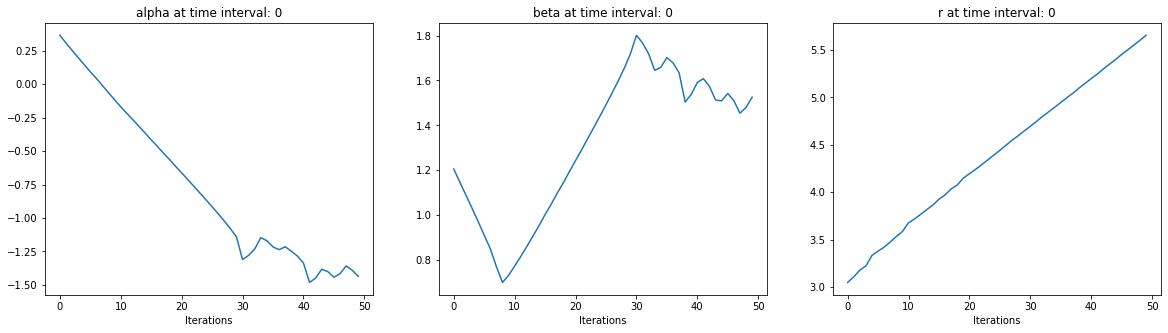

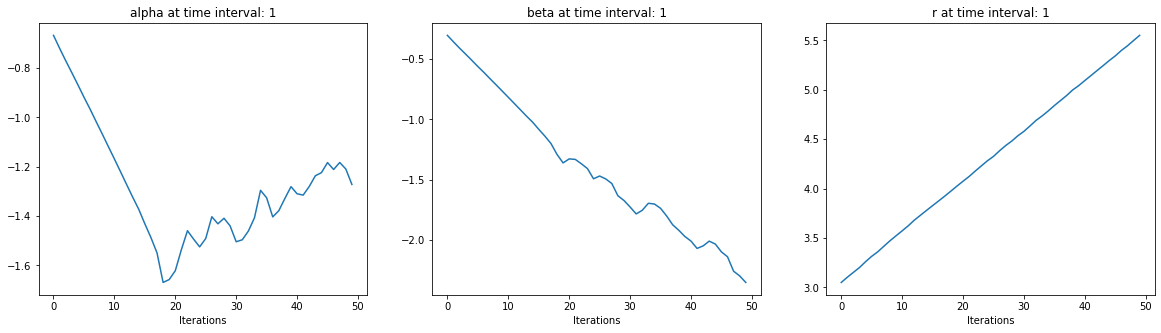

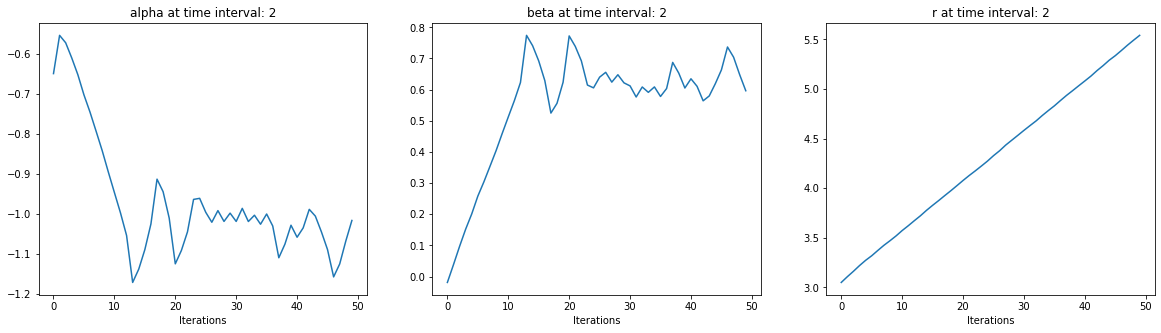

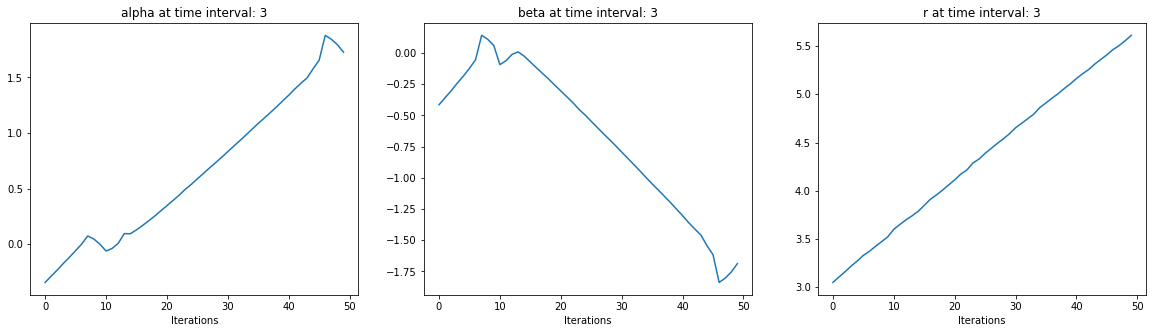

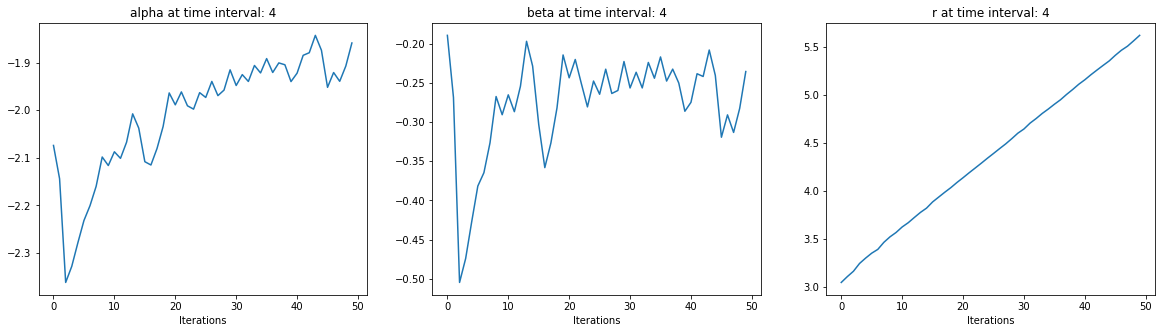

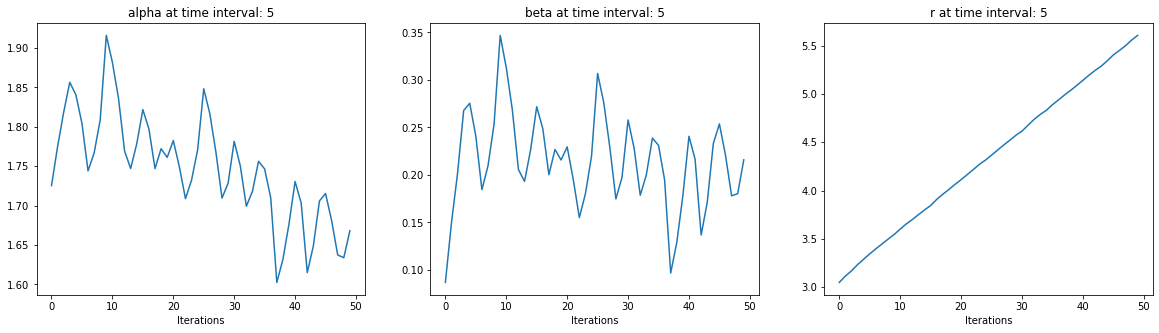

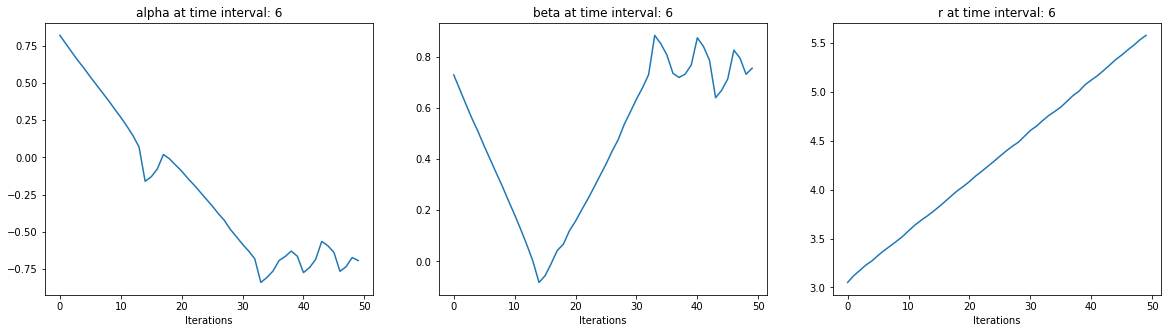

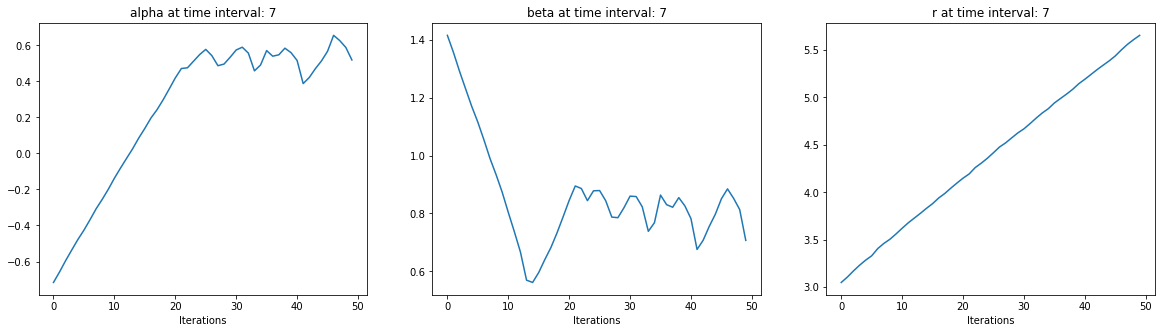

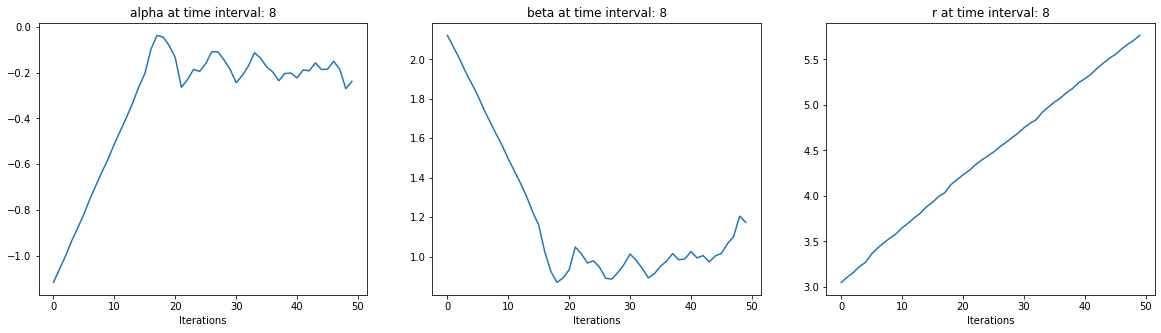

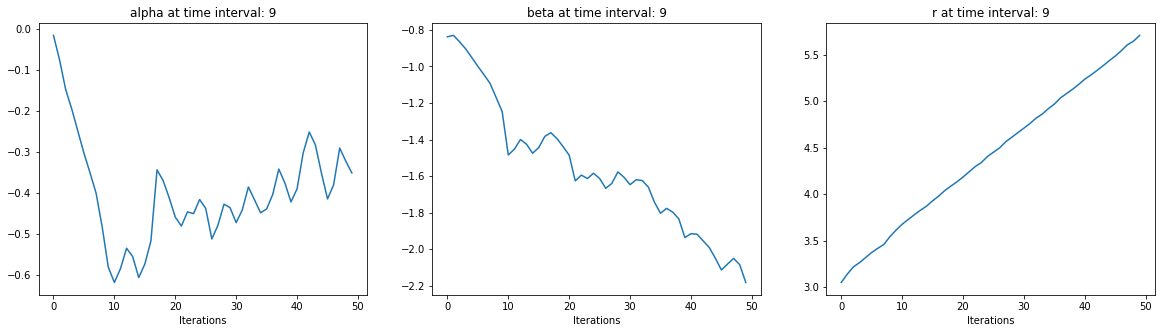

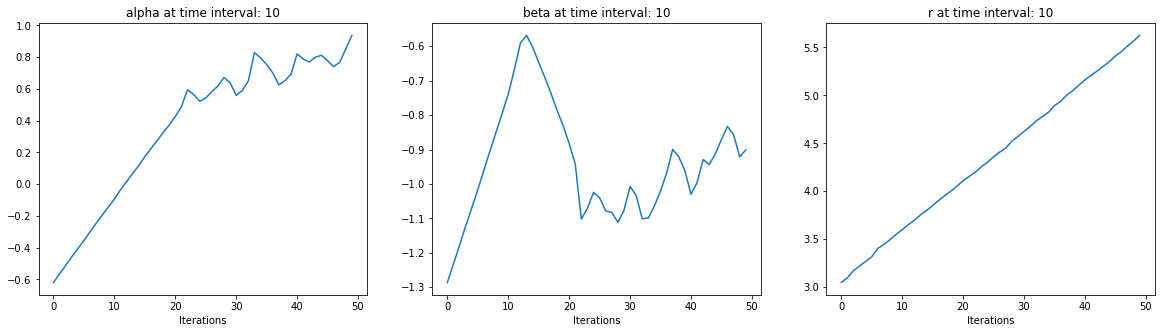

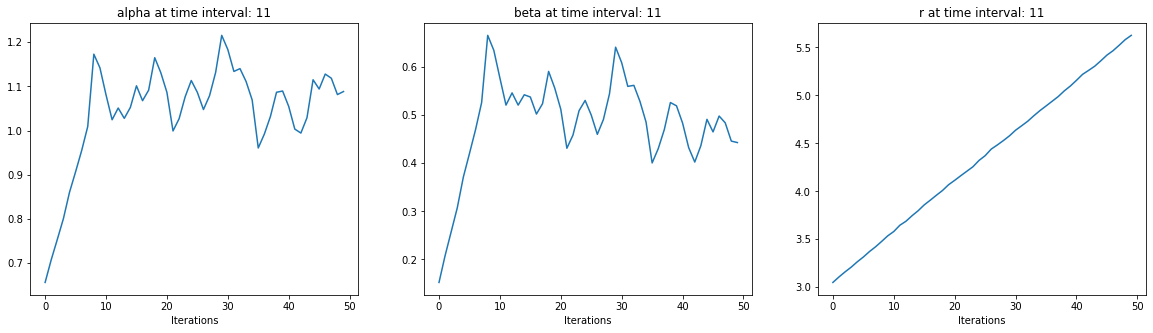

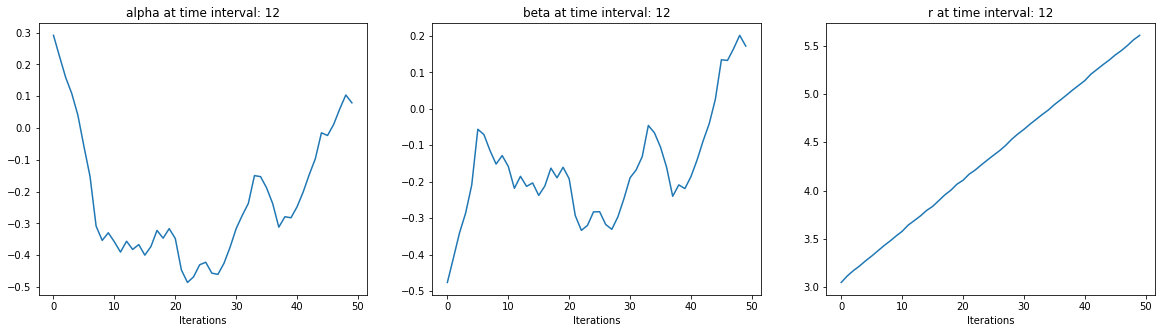

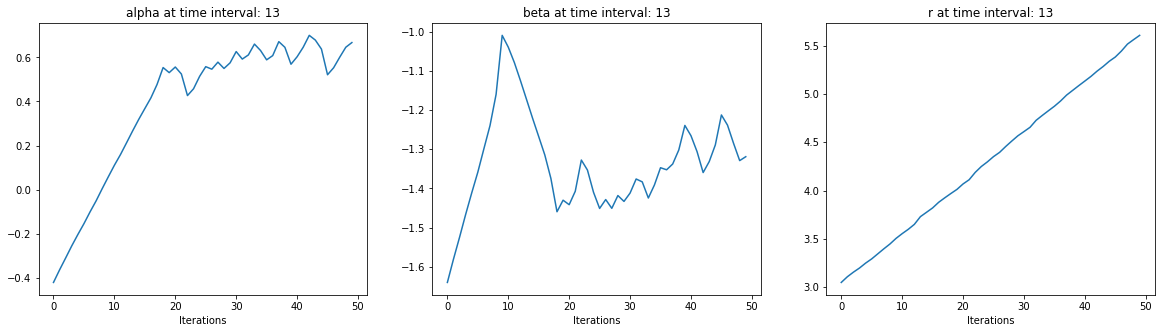

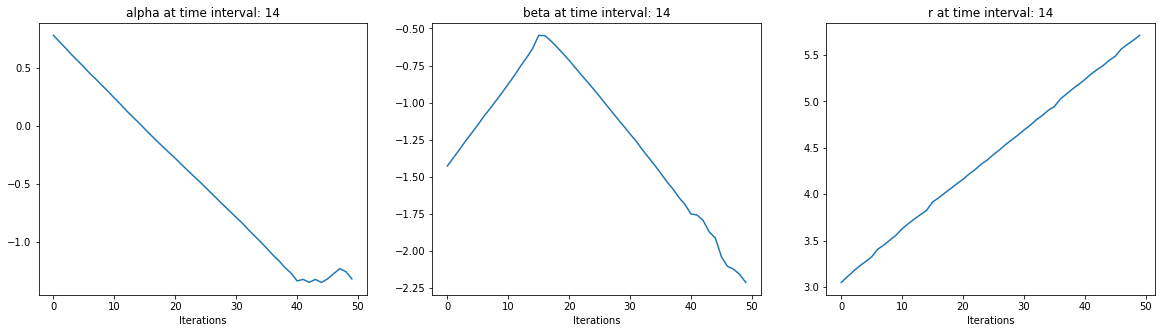

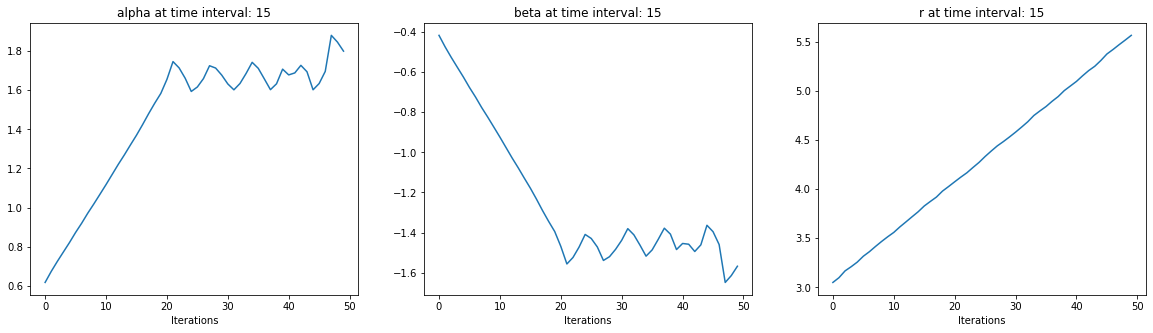

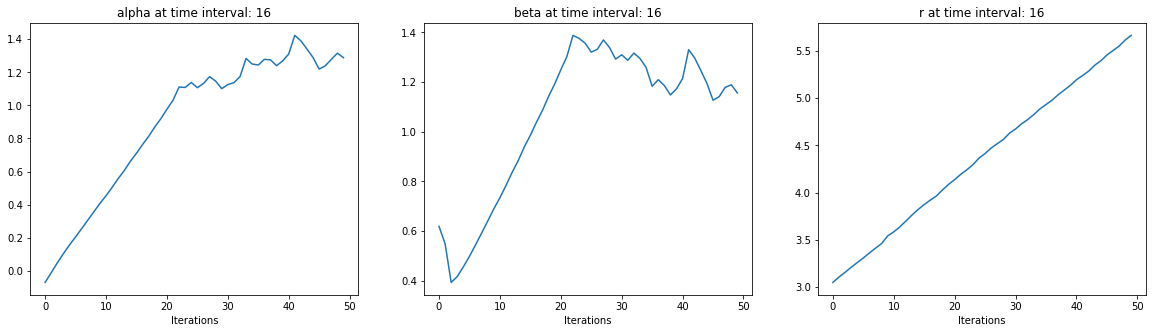

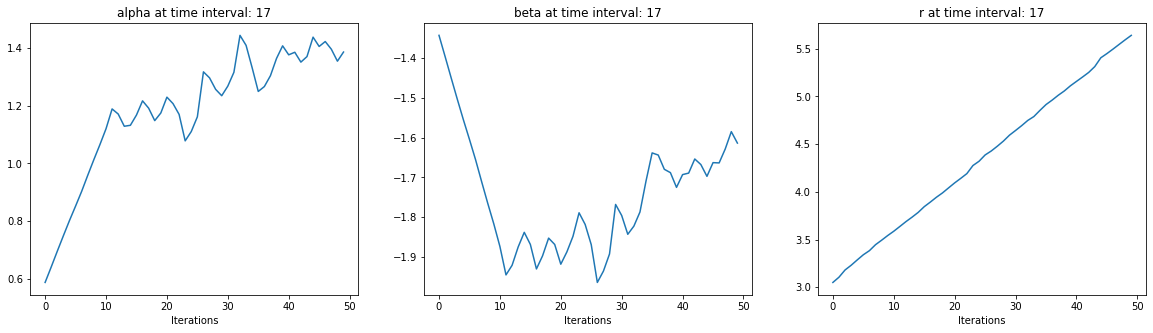

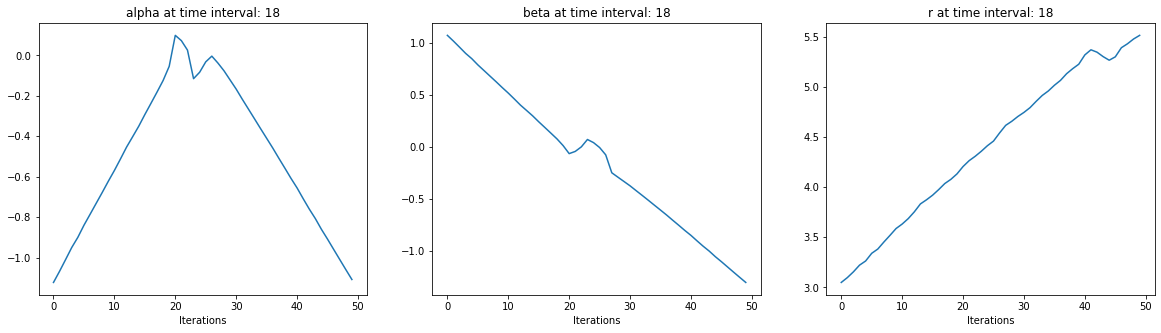

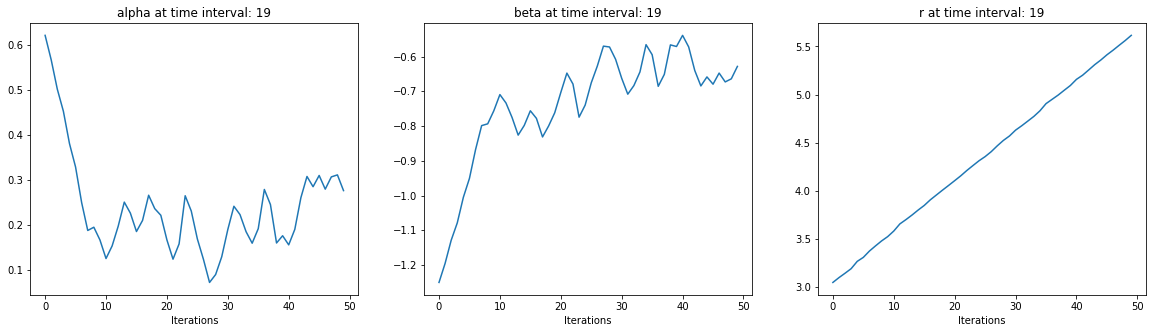

In [26]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax = plt.subplots(nrows=1, ncols=P, figsize=(20, 5))
        for j, ax in enumerate(ax.ravel()):
            ax.plot(vp__pars[par_names[j]][t, :])
            ax.set_title(par_names[j] + " at time interval: %d" % t)
            ax.set_xlabel("Iterations")
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

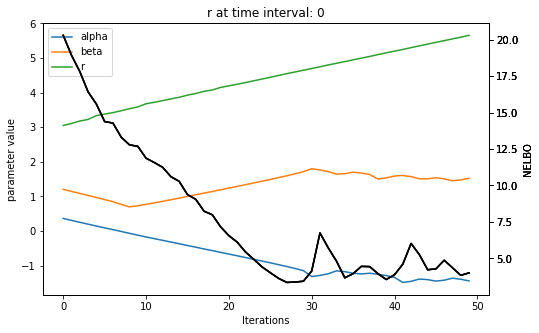

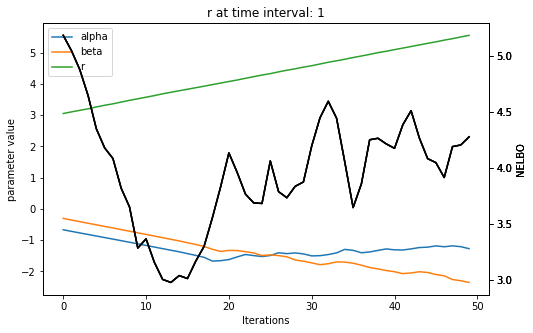

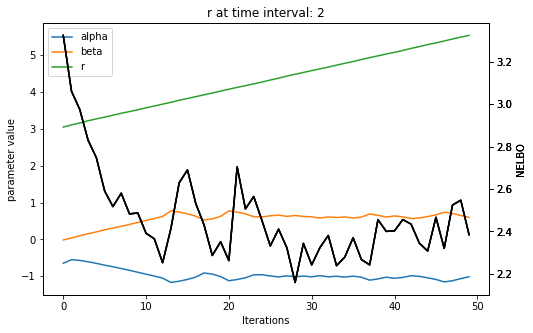

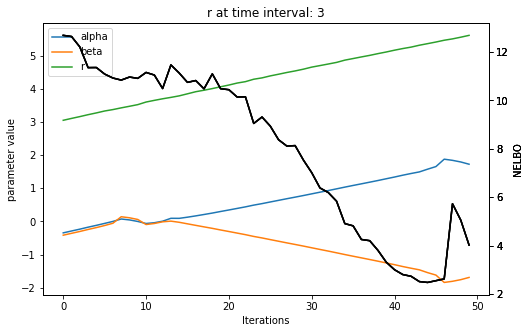

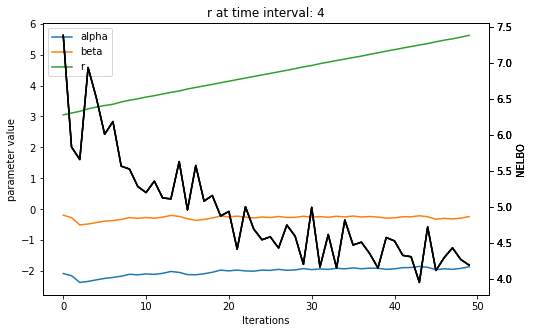

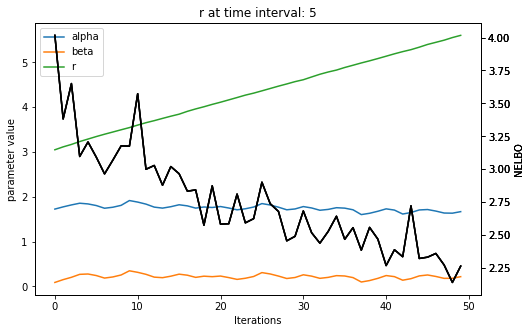

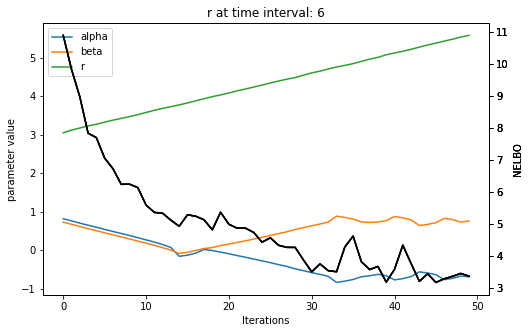

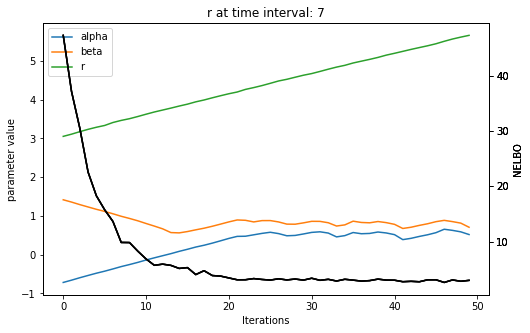

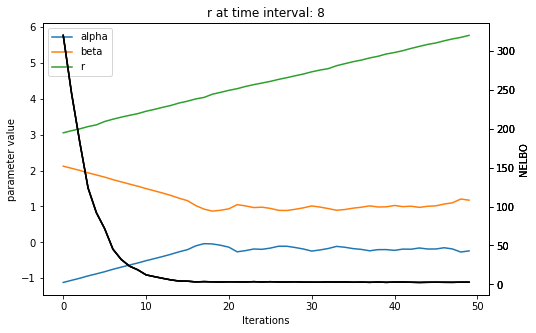

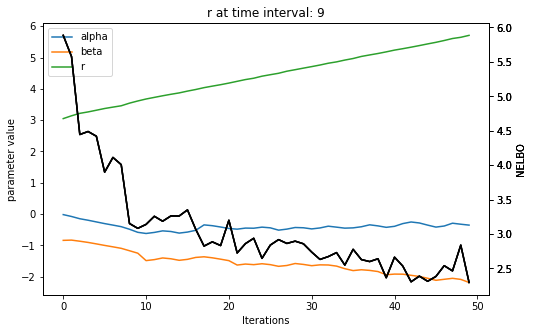

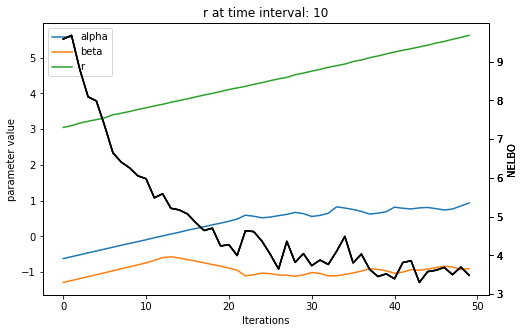

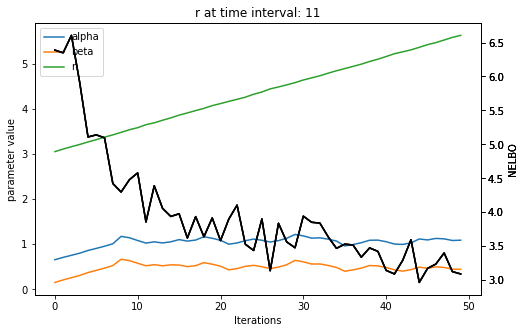

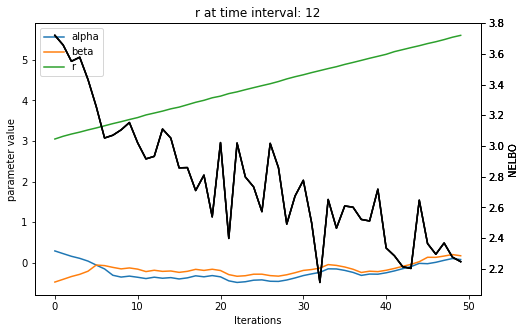

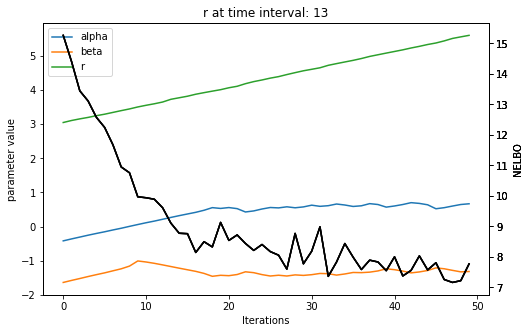

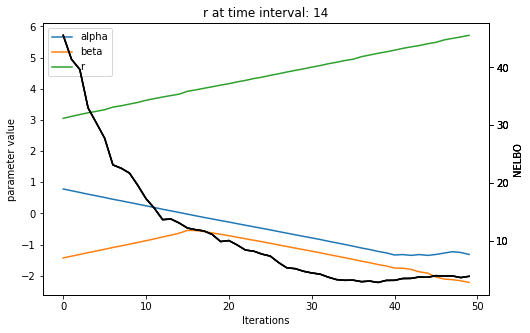

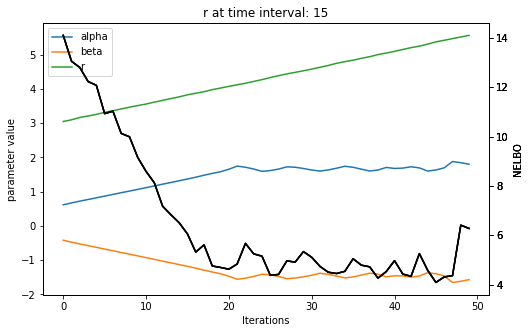

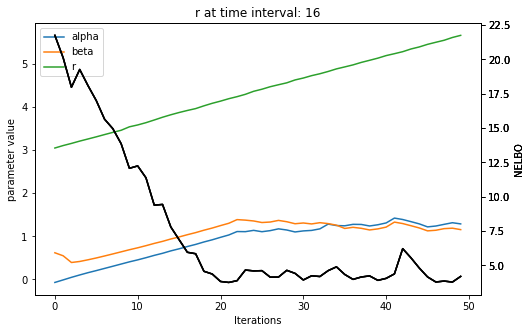

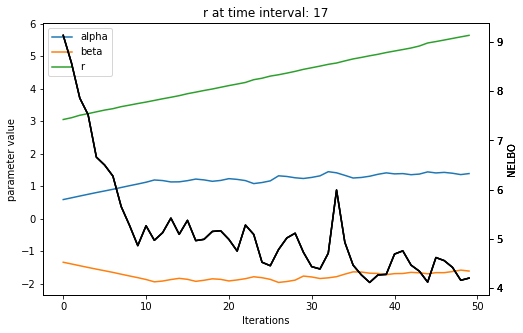

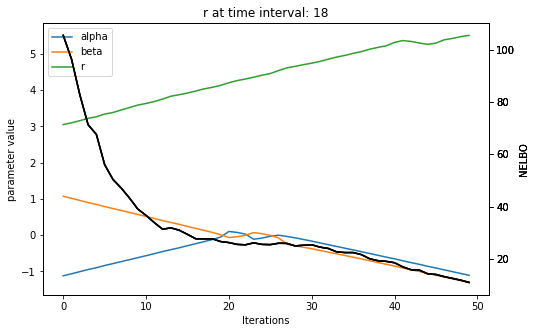

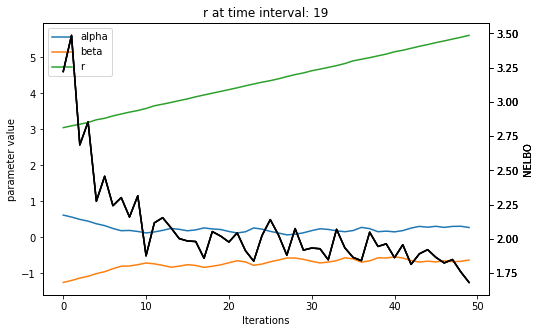

In [27]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

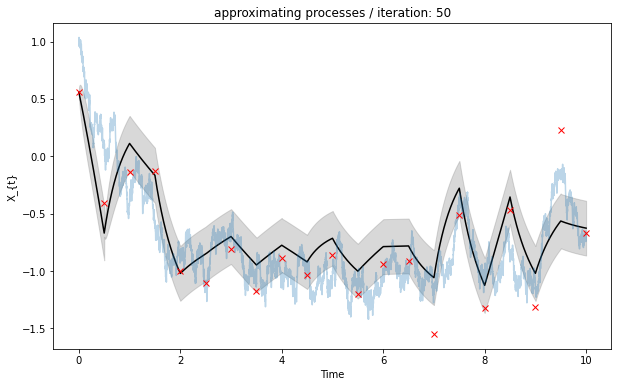

In [28]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.3)
    plt.plot(obs_time, obs, 'rx')
    plt.xlabel("Time")
    plt.ylabel(r"X_{t}")
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

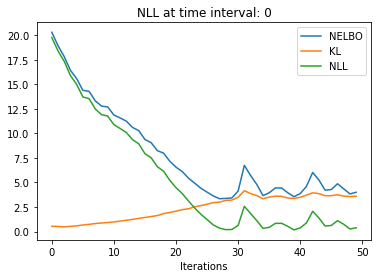

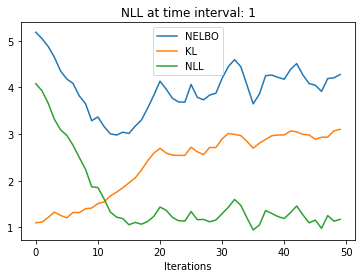

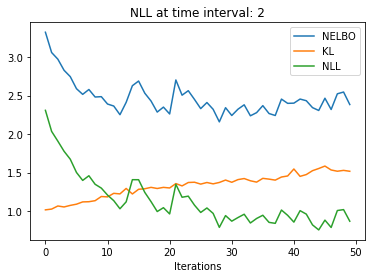

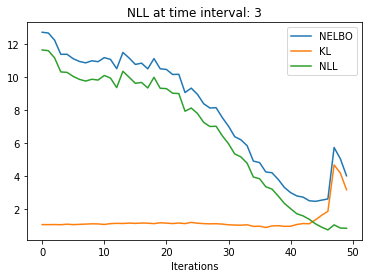

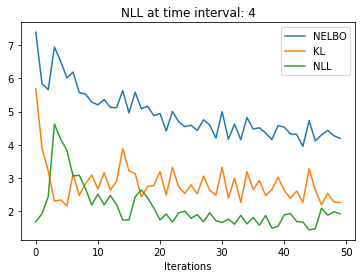

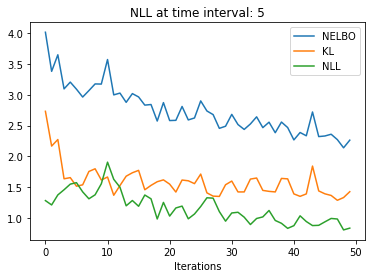

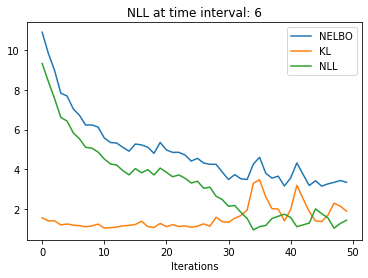

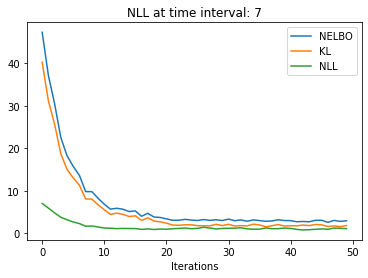

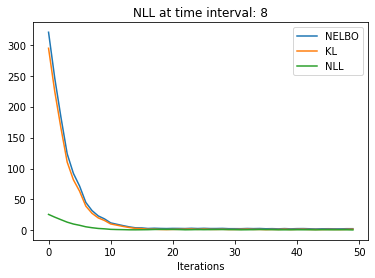

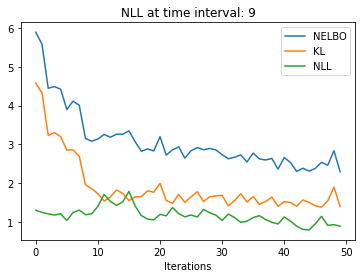

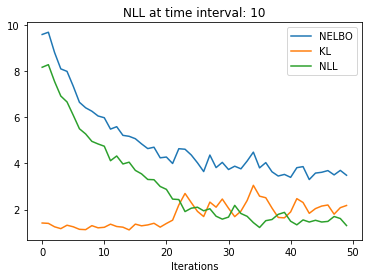

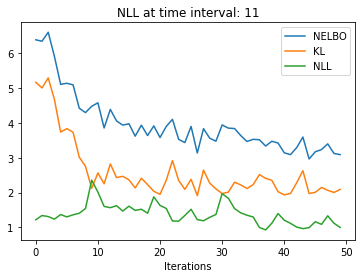

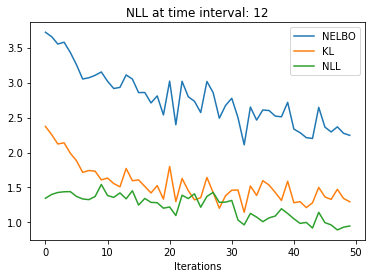

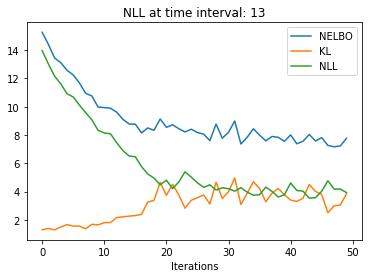

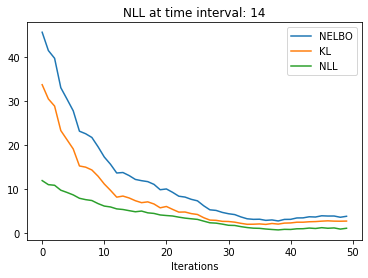

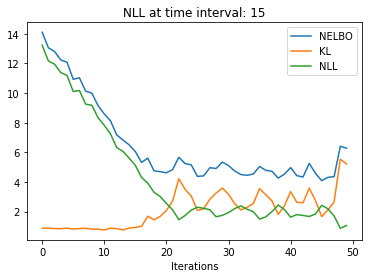

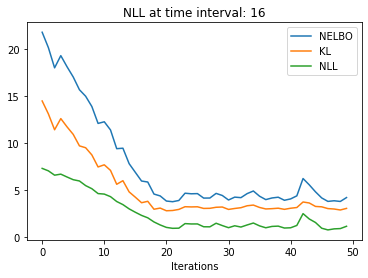

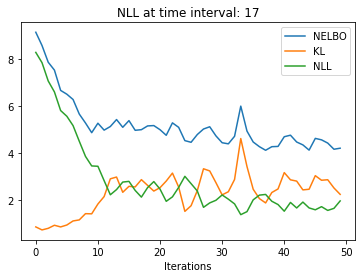

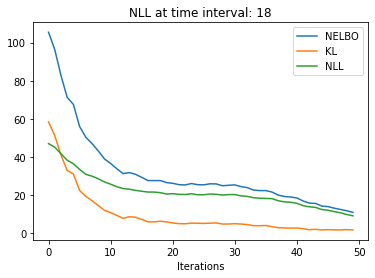

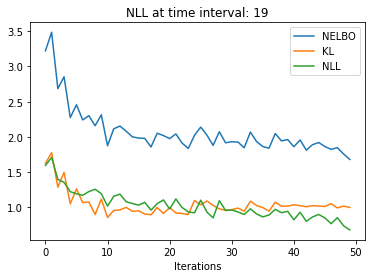

In [29]:
it_names = ['50']
obj_names = ['NELBO', 'KL', 'NLL']
for item, name in zip(output, it_names):
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        plt.plot(figsize=(8, 6))
        for j in range(len(obj_names)):
            plt.plot(vp__obj[obj_names[j]][t], label=obj_names[j])
            plt.title(obj_names[j] + " at time interval: %d" % t)
            plt.xlabel("Iterations")
#             ax1.set_ylabel(obj_names[j])
            plt.legend()
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

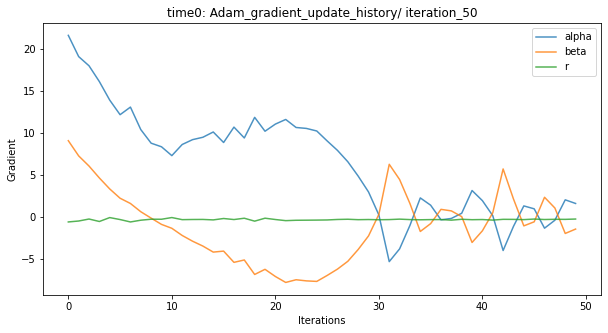

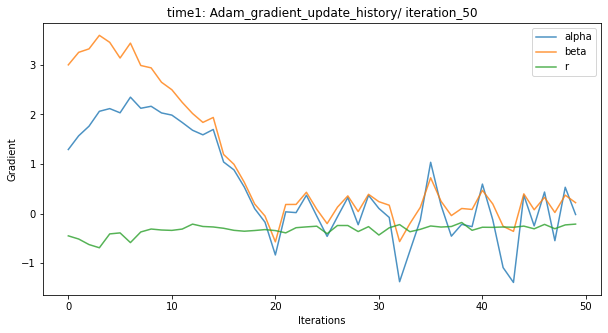

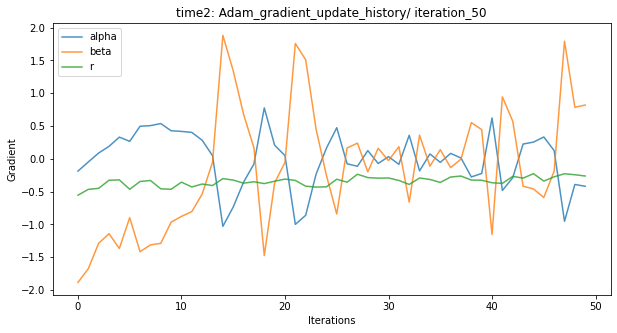

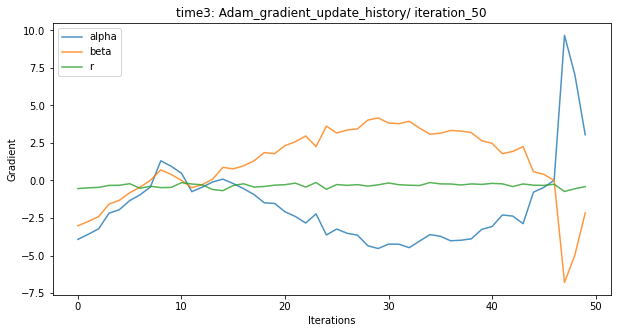

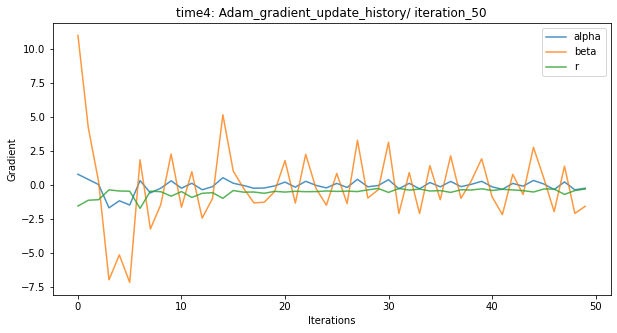

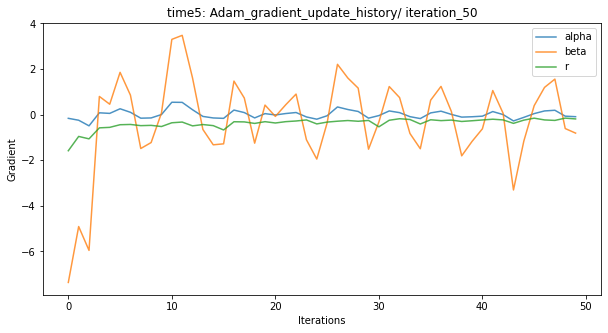

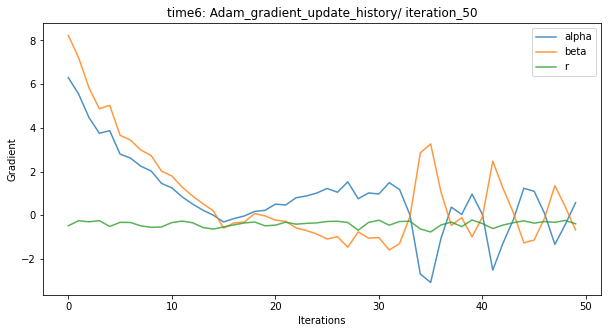

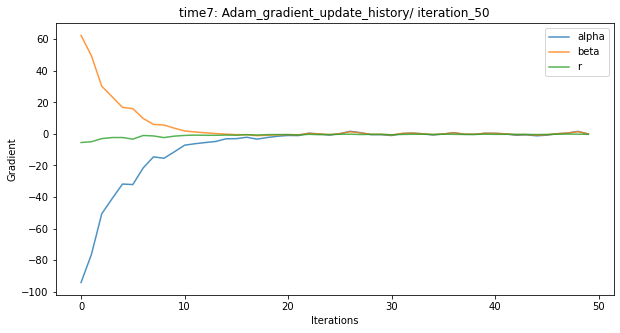

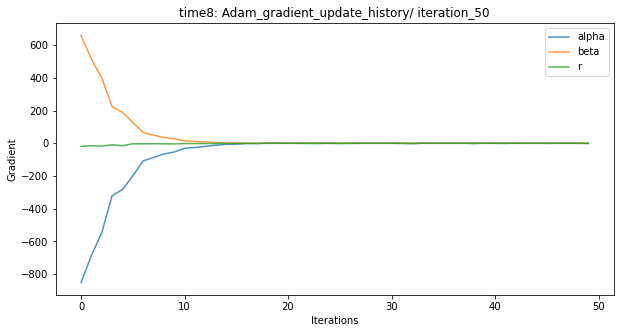

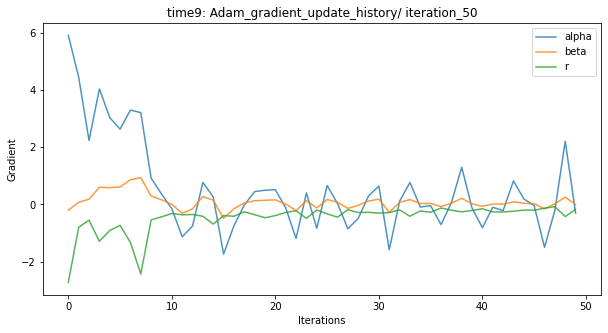

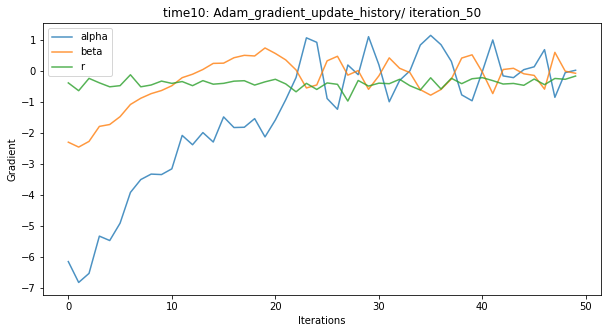

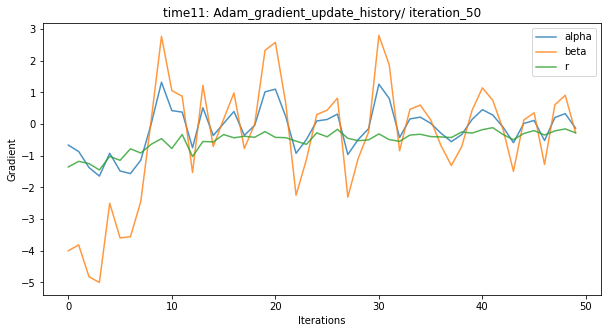

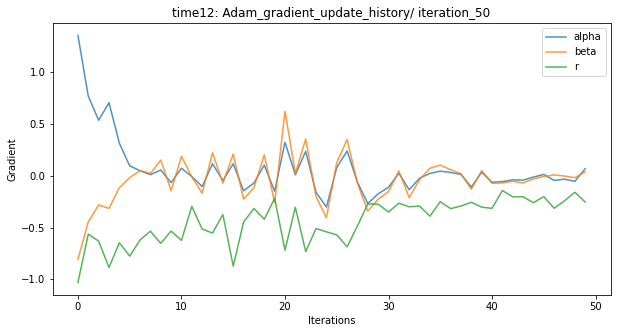

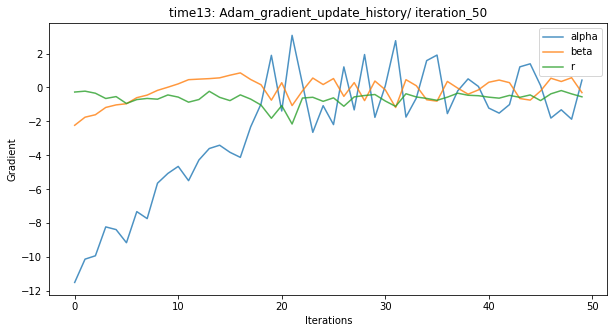

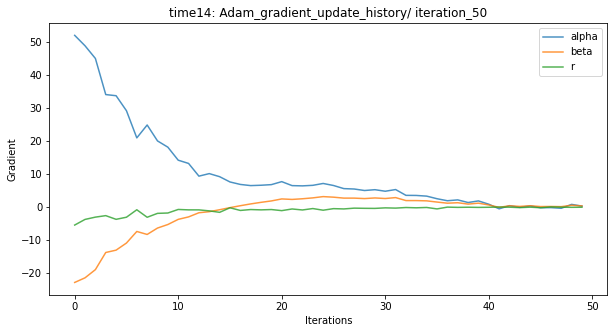

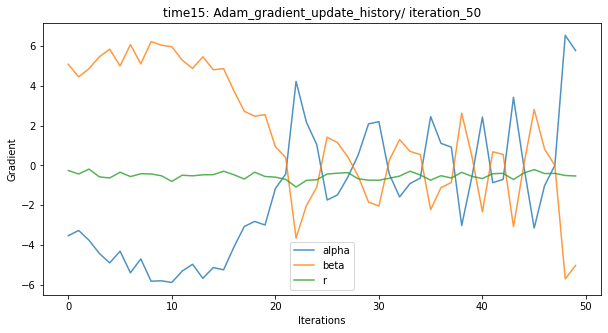

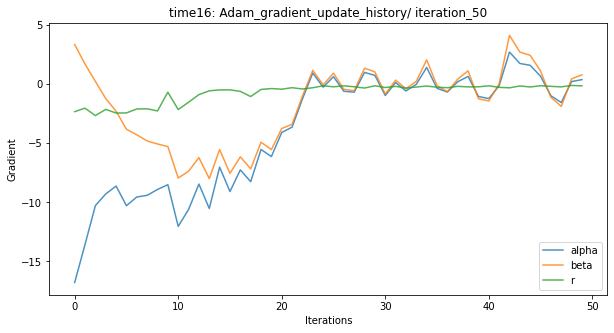

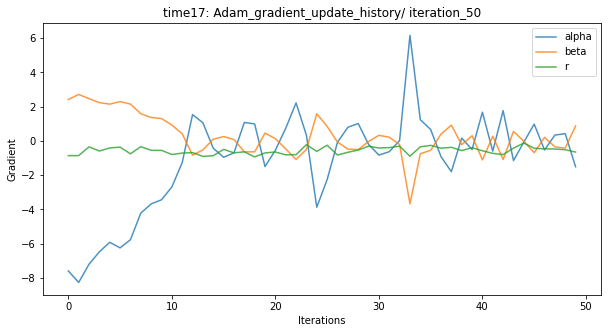

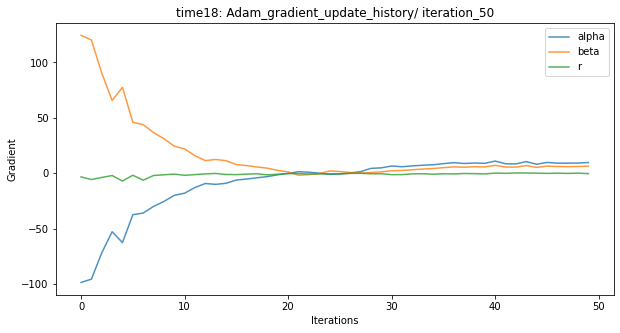

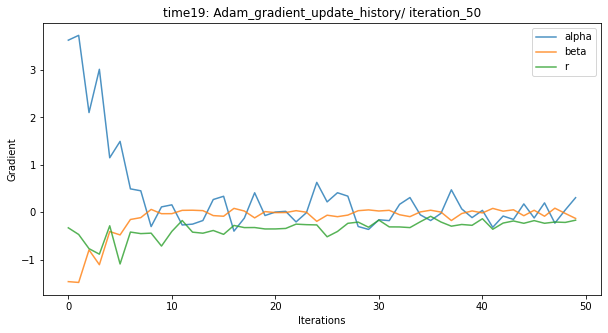

In [30]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp_grads = item[4]
    for t in range(T-1):
        plt.figure(figsize=(10,5))

        for key in vp_grads.keys():
            plt.plot(vp_grads[key][t], label=key, alpha=0.8)
            plt.ylabel("Gradient")
            plt.xlabel("Iterations")
#             plt.axhline(np.mean(vp_grads[key][t]), linestyle='dashed', label=str(np.mean(vp_grads[key]).round(2)))
            plt.legend()

        file_name = "time" + str(t) + ": Adam_" + "gradient_update_history/ " + "iteration_" + name
        plt.title(file_name)
#     plt.savefig("figures/" + file_name)
    plt.show()

In [31]:
with open('EX03_DW_BVI', 'wb') as f:
    pickle.dump(output[0], f)

Fix $\alpha$ and optimize the other paramters, $\beta, r$

In [ ]:
fix_pars = {'alpha': torch.tensor(1.)}

In [ ]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = fix_pars,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.3, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

In [ ]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    plt.xlabel("Time")
    plt.ylabel(r"X_{t}")
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

FIX $\beta$

In [ ]:
fix_pars = {'beta': torch.tensor(1.)}

In [ ]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = fix_pars, K=500,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.3, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

In [ ]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    plt.xlabel("Time")
    plt.ylabel(r"X_{t}")
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

In [ ]:
it_names = ['50']
obj_names = ['NELBO', 'KL', 'NLL']
for item, name in zip(output, it_names):
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        plt.plot(figsize=(8, 6))
        for j in range(len(obj_names)):
            plt.plot(vp__obj[obj_names[j]][t], label=obj_names[j])
            plt.title(obj_names[j] + " at time interval: %d" % t)
            plt.xlabel("Iterations")
#             ax1.set_ylabel(obj_names[j])
            plt.legend()
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

FIX $\alpha, \beta$

In [ ]:
fix_pars = {'beta': torch.tensor(1.), 'alpha':torch.tensor(2.)}

In [ ]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = fix_pars,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.1, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

In [ ]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    plt.xlabel("Time")
    plt.ylabel(r"X_{t}")
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

what if we reduce the time step by factor of 50?

In [ ]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time/50, obs_sigma, \
                                                      init_state="Random", M=1500, \
#                                                       FIX_PAR = fix_pars,
#                                                                \
                                                      IT=it, vN=150, learning_rate=0.15, \
                                                      Optimizer="Adam", beta_1 = 0.5, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

In [ ]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(-1 * vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts/50, true_sde_trj, alpha=0.2)
    plt.plot(obs_time/50, obs, 'rx')
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

In [ ]:
it_names = ['50']
obj_names = ['NELBO', 'KL', 'NLL']
for item, name in zip(output, it_names):
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        plt.plot(figsize=(8, 6))
        for j in range(len(obj_names)):
            plt.plot(vp__obj[obj_names[j]][t], label=obj_names[j])
            plt.title(obj_names[j] + " at time interval: %d" % t)
            plt.xlabel("Iterations")
#             ax1.set_ylabel(obj_names[j])
            plt.legend()
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()